In [1]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import os
import sys
import csv
import talib
from   scipy.stats       import norm
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf

In [2]:
df_ = pd.read_csv("./data/EURUSD.csv", parse_dates=True, index_col="datetime")

In [3]:
df_

,Open,High,Low,Close,Volume,Spread
datetime,,,,,,
2009-10-20 04:14:00+00:00,1.49814,1.49816,1.49812,1.49812,12,17
2009-10-20 04:15:00+00:00,1.49810,1.49822,1.49806,1.49820,24,16
2009-10-20 04:16:00+00:00,1.49819,1.49820,1.49805,1.49807,22,16
2009-10-20 04:17:00+00:00,1.49805,1.49805,1.49801,1.49803,6,16
2009-10-20 04:18:00+00:00,1.49801,1.49801,1.49789,1.49799,28,16
...,...,...,...,...,...,...
2023-10-16 03:35:00+00:00,1.05200,1.05206,1.05197,1.05206,21,9
2023-10-16 03:36:00+00:00,1.05206,1.05217,1.05206,1.05217,12,9
2023-10-16 03:37:00+00:00,1.05217,1.05217,1.05214,1.05217,6,9


In [6]:
timeframe_by_minute = 30

In [7]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2009-10-20 04:00:00+00:00,1.49814,1.49822,1.49742,1.49781,299
2009-10-20 04:30:00+00:00,1.49783,1.49796,1.49644,1.49725,703
2009-10-20 05:00:00+00:00,1.49724,1.49773,1.49693,1.49713,610
2009-10-20 05:30:00+00:00,1.49712,1.49846,1.49653,1.49805,924
2009-10-20 06:00:00+00:00,1.49804,1.49807,1.49657,1.49744,949
...,...,...,...,...,...
2023-10-16 01:30:00+00:00,1.05243,1.05251,1.05205,1.05216,728
2023-10-16 02:00:00+00:00,1.05216,1.05255,1.05196,1.05234,510
2023-10-16 02:30:00+00:00,1.05234,1.05241,1.05200,1.05213,411


mean    : 49.826884194251825
std.dev : 12.183566704903704
sigma lower : 25.5
sigma upper : 74.2


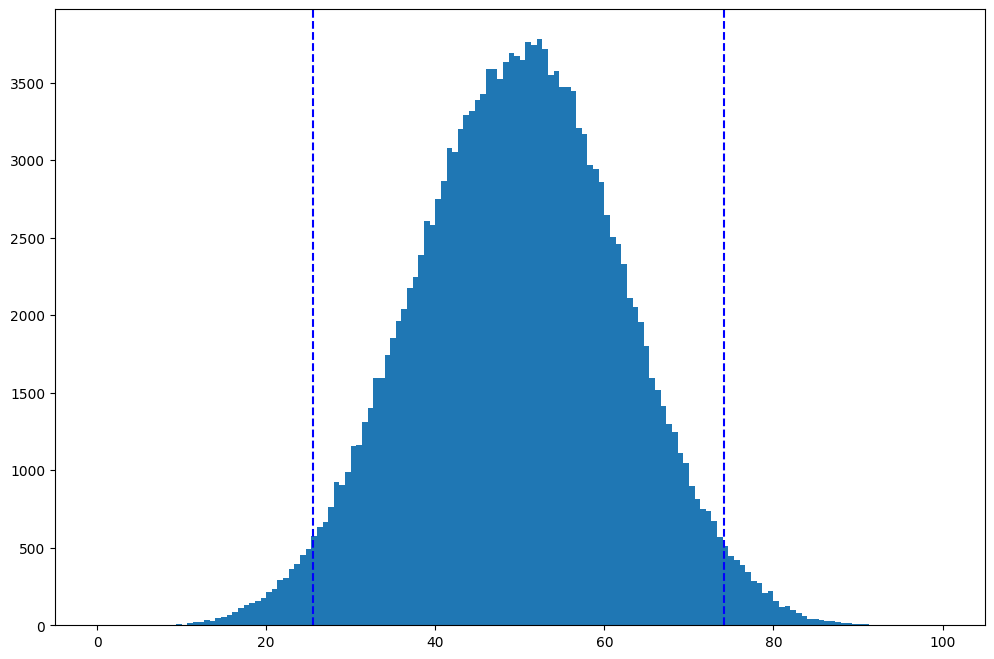

In [8]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [9]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    1305
-1.0    1285
Name: count, dtype: int64

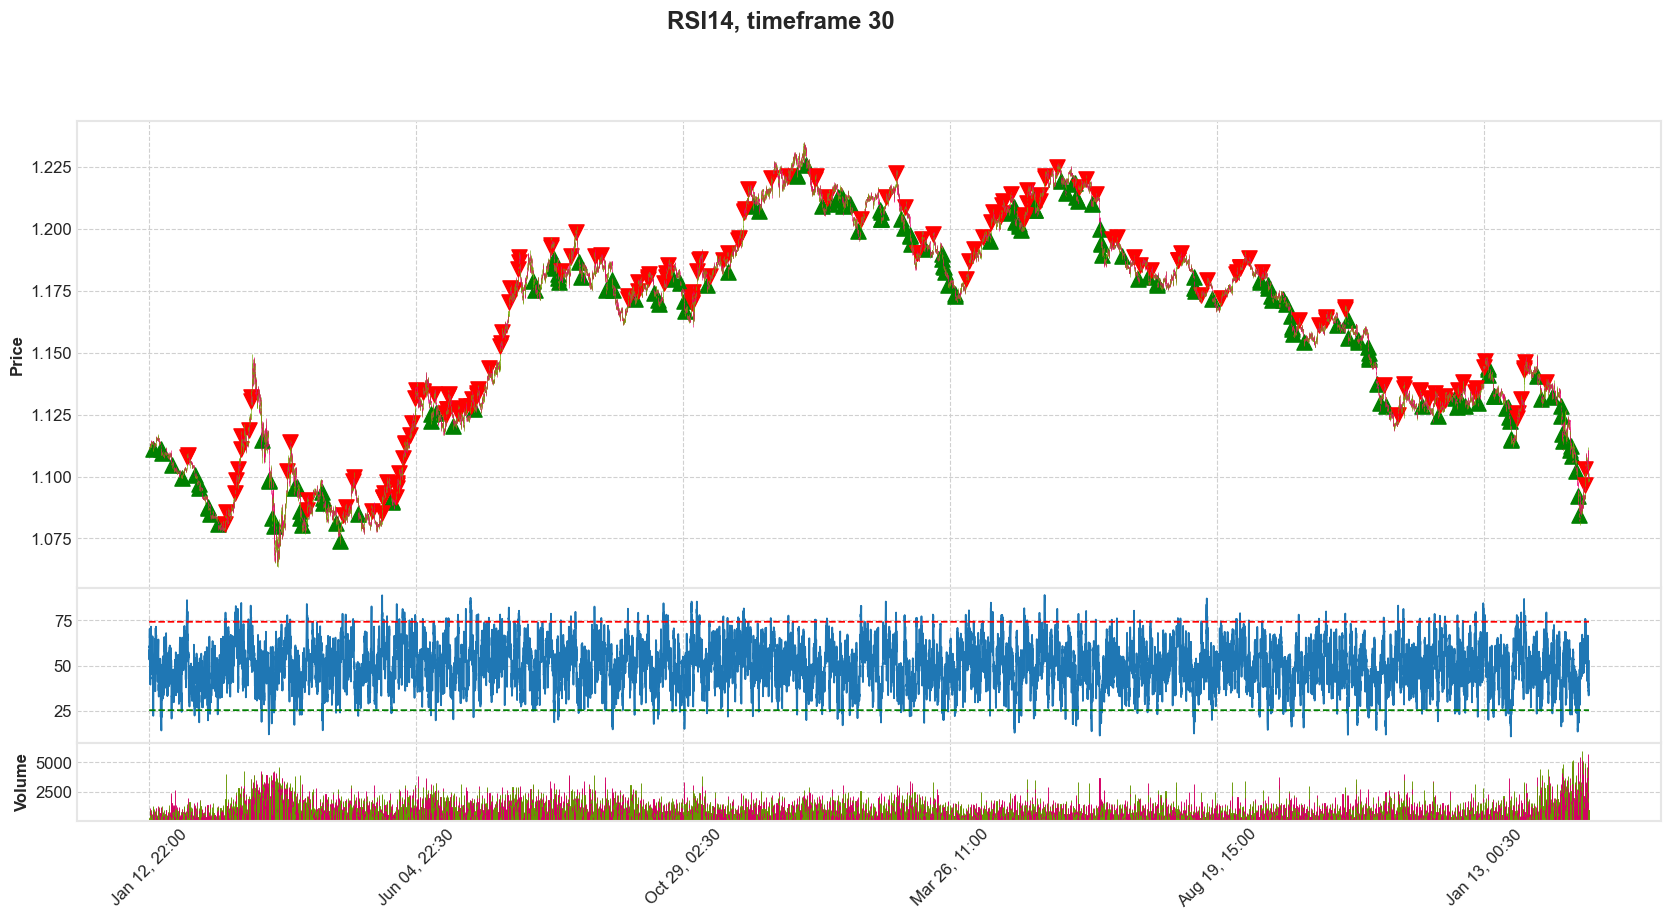

In [10]:
plot_df = df["2020-01-12 10:00:00":"2022-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [11]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

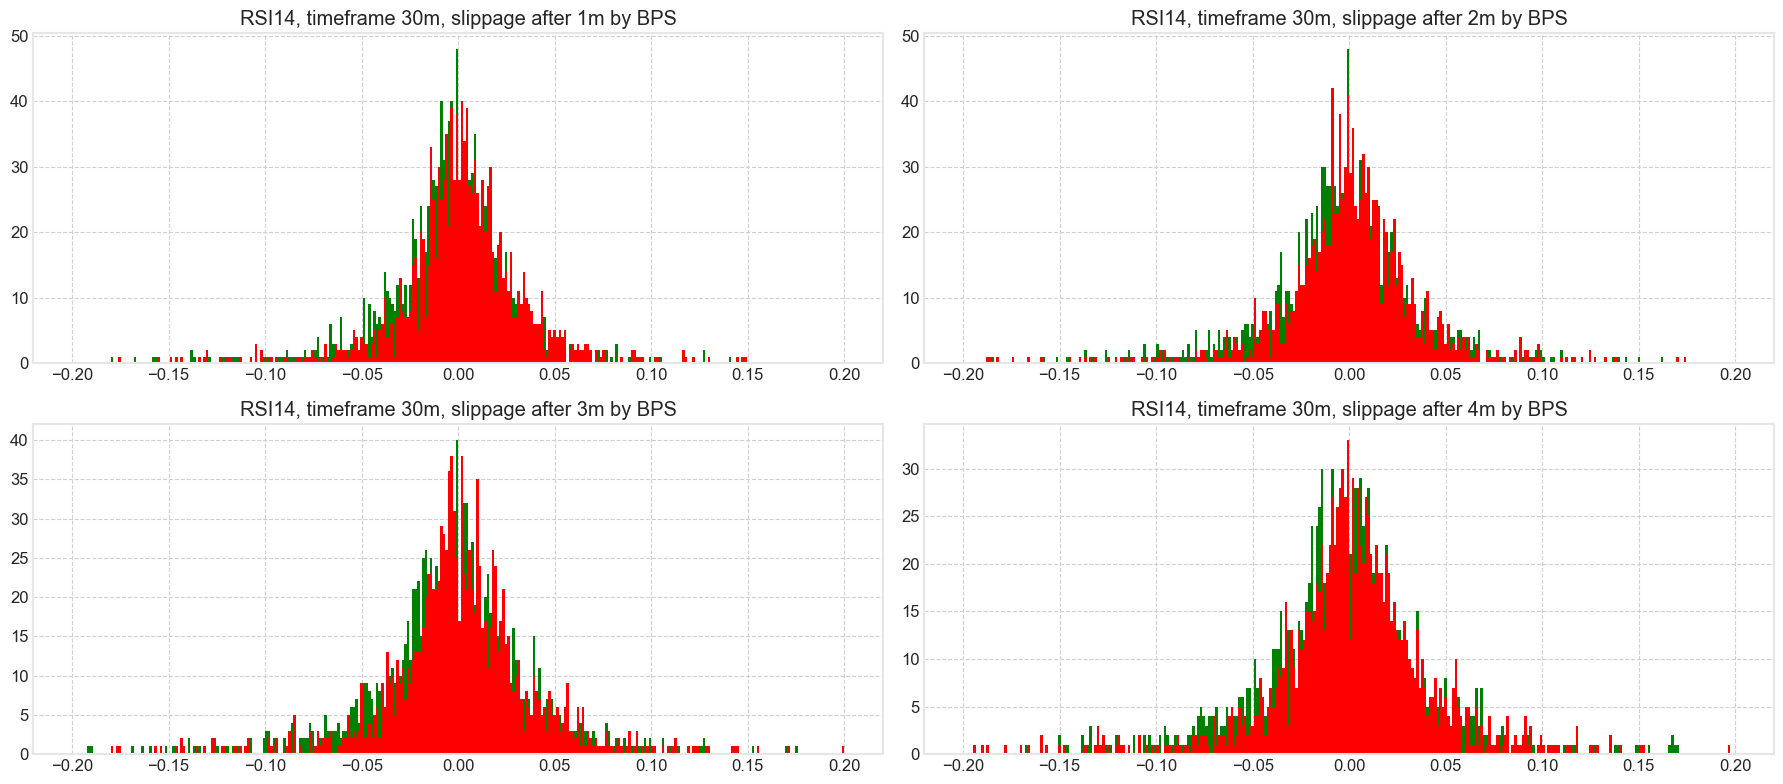

In [12]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [13]:
timeframe_by_hours  = 1
timeframe_by_minute = timeframe_by_hours*60

In [14]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2009-10-20 04:00:00+00:00,1.49814,1.49822,1.49644,1.49725,1002
2009-10-20 05:00:00+00:00,1.49724,1.49846,1.49653,1.49805,1534
2009-10-20 06:00:00+00:00,1.49804,1.49808,1.49657,1.49781,1879
2009-10-20 07:00:00+00:00,1.49785,1.49870,1.49655,1.49857,3018
2009-10-20 08:00:00+00:00,1.49855,1.49866,1.49560,1.49613,3128
...,...,...,...,...,...
2023-10-15 23:00:00+00:00,1.05213,1.05222,1.05168,1.05216,745
2023-10-16 00:00:00+00:00,1.05218,1.05234,1.05153,1.05173,1564
2023-10-16 01:00:00+00:00,1.05173,1.05251,1.05173,1.05216,1319


mean    : 49.67425942620095
std.dev : 12.677615141238604
sigma lower : 24.3
sigma upper : 75.0


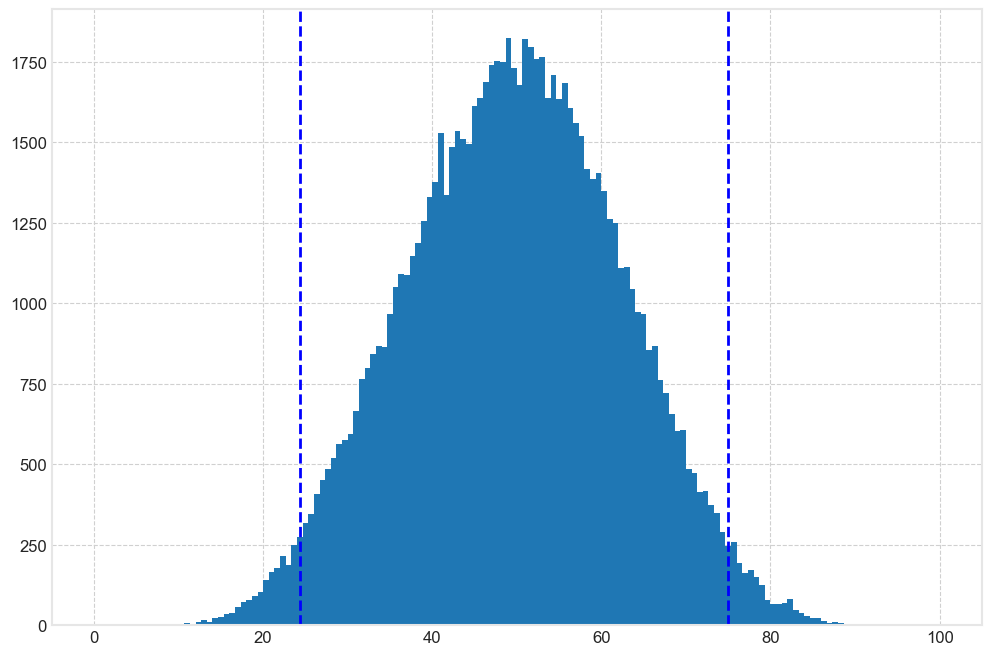

In [15]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [16]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    598
-1.0    588
Name: count, dtype: int64

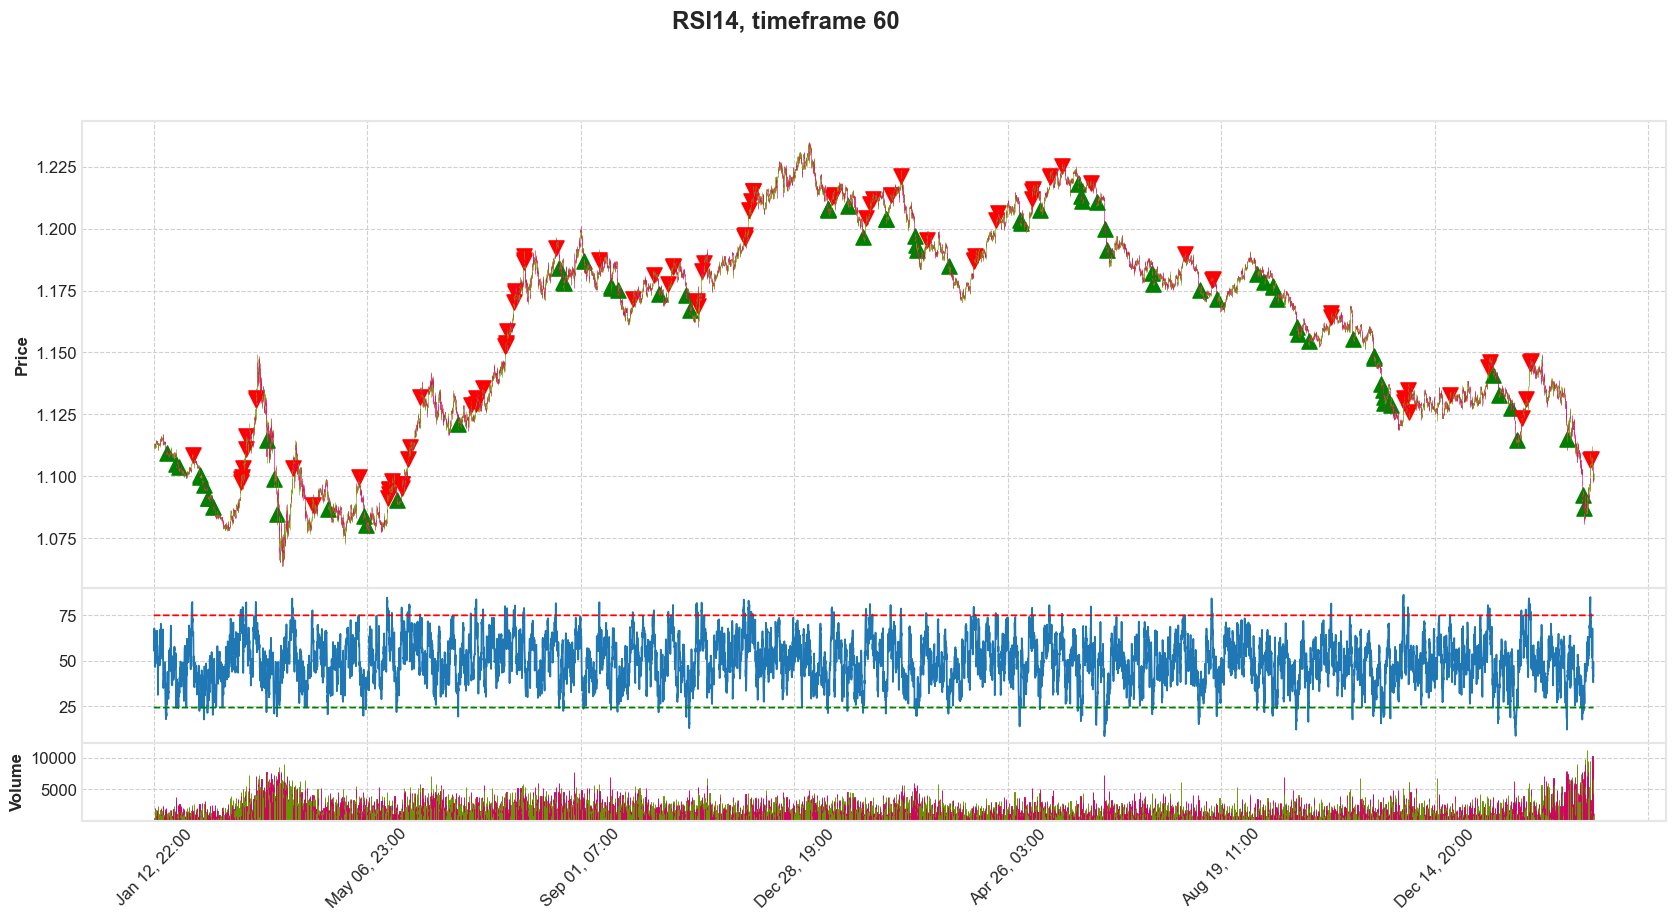

In [17]:
plot_df = df["2020-01-12 10:00:00":"2022-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [18]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

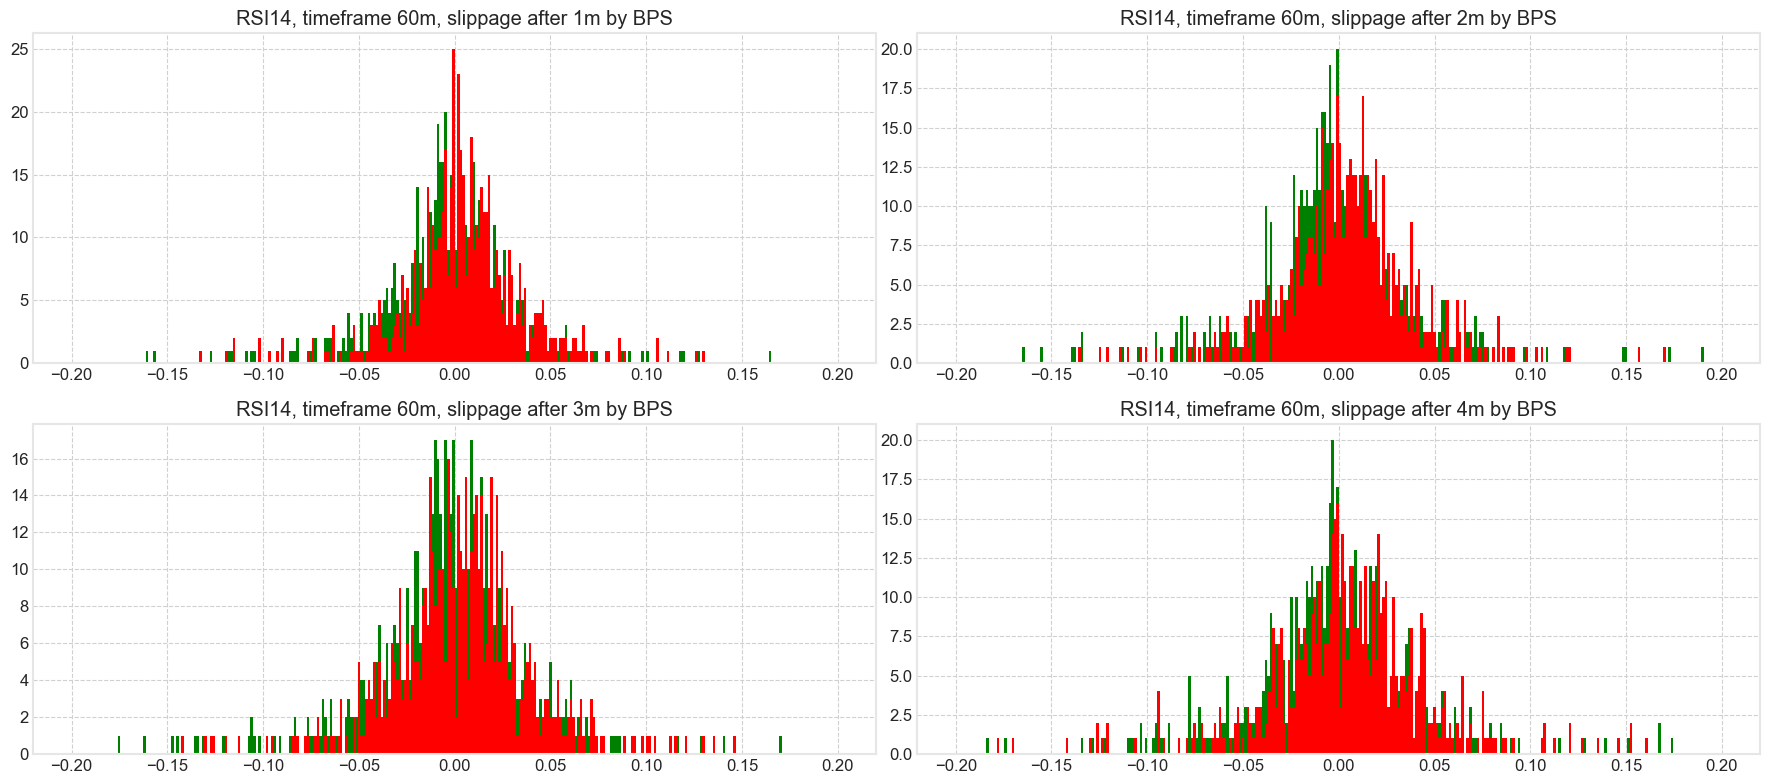

In [19]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [20]:
timeframe_by_hours  = 4
timeframe_by_minute = timeframe_by_hours*60

In [21]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2009-10-20 04:00:00+00:00,1.49814,1.49870,1.49644,1.49857,7433
2009-10-20 08:00:00+00:00,1.49855,1.49866,1.49540,1.49677,10690
2009-10-20 12:00:00+00:00,1.49680,1.49900,1.49237,1.49425,13252
2009-10-20 16:00:00+00:00,1.49426,1.49452,1.48823,1.49265,10517
2009-10-20 20:00:00+00:00,1.49264,1.49451,1.49161,1.49358,4325
...,...,...,...,...,...
2023-10-13 12:00:00+00:00,1.05244,1.05471,1.04950,1.05002,20812
2023-10-13 16:00:00+00:00,1.05004,1.05156,1.04992,1.05133,9189
2023-10-13 20:00:00+00:00,1.05133,1.05136,1.05053,1.05065,949


mean    : 49.35378650468629
std.dev : 13.053854693968763
sigma lower : 23.2
sigma upper : 75.5


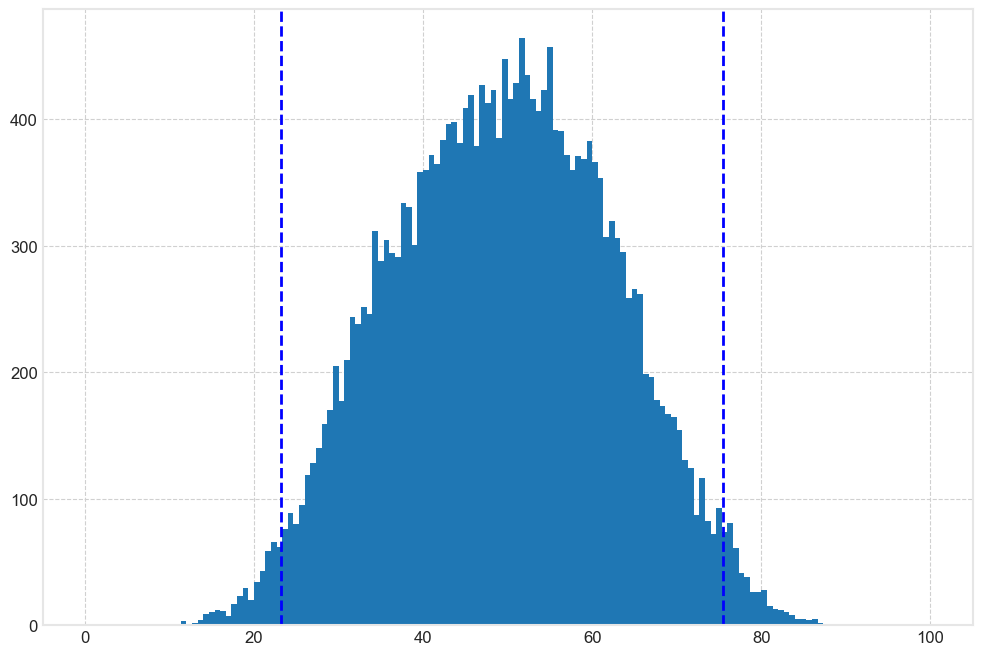

In [22]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [23]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
-1.0    151
 1.0    133
Name: count, dtype: int64

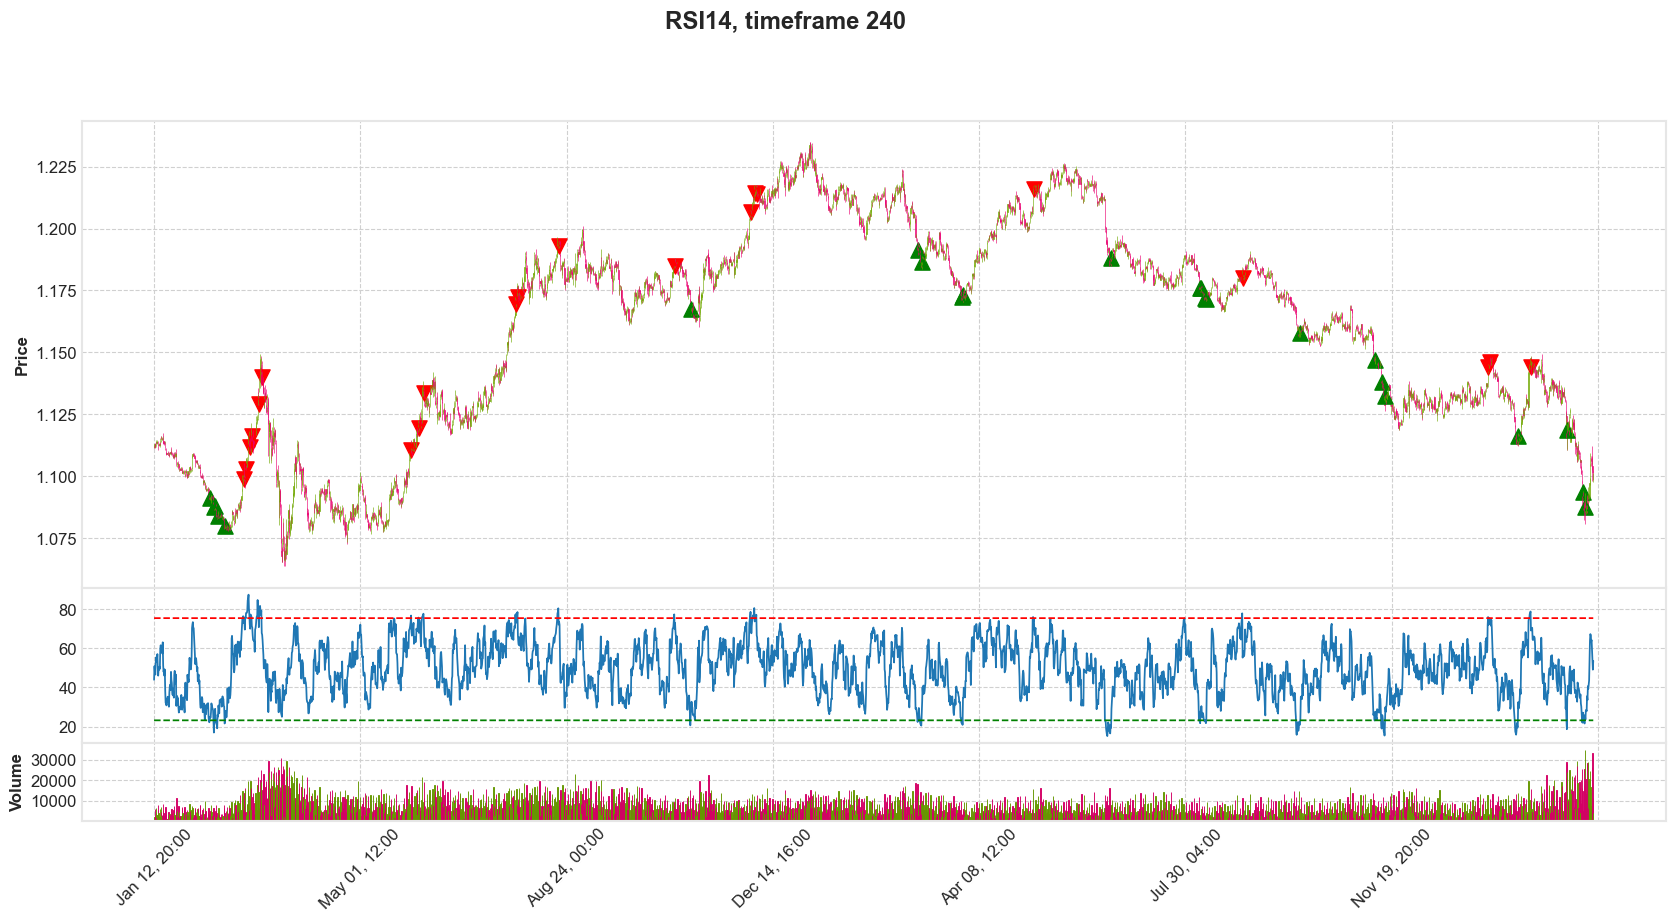

In [24]:
plot_df = df["2020-01-12 10:00:00":"2022-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [25]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

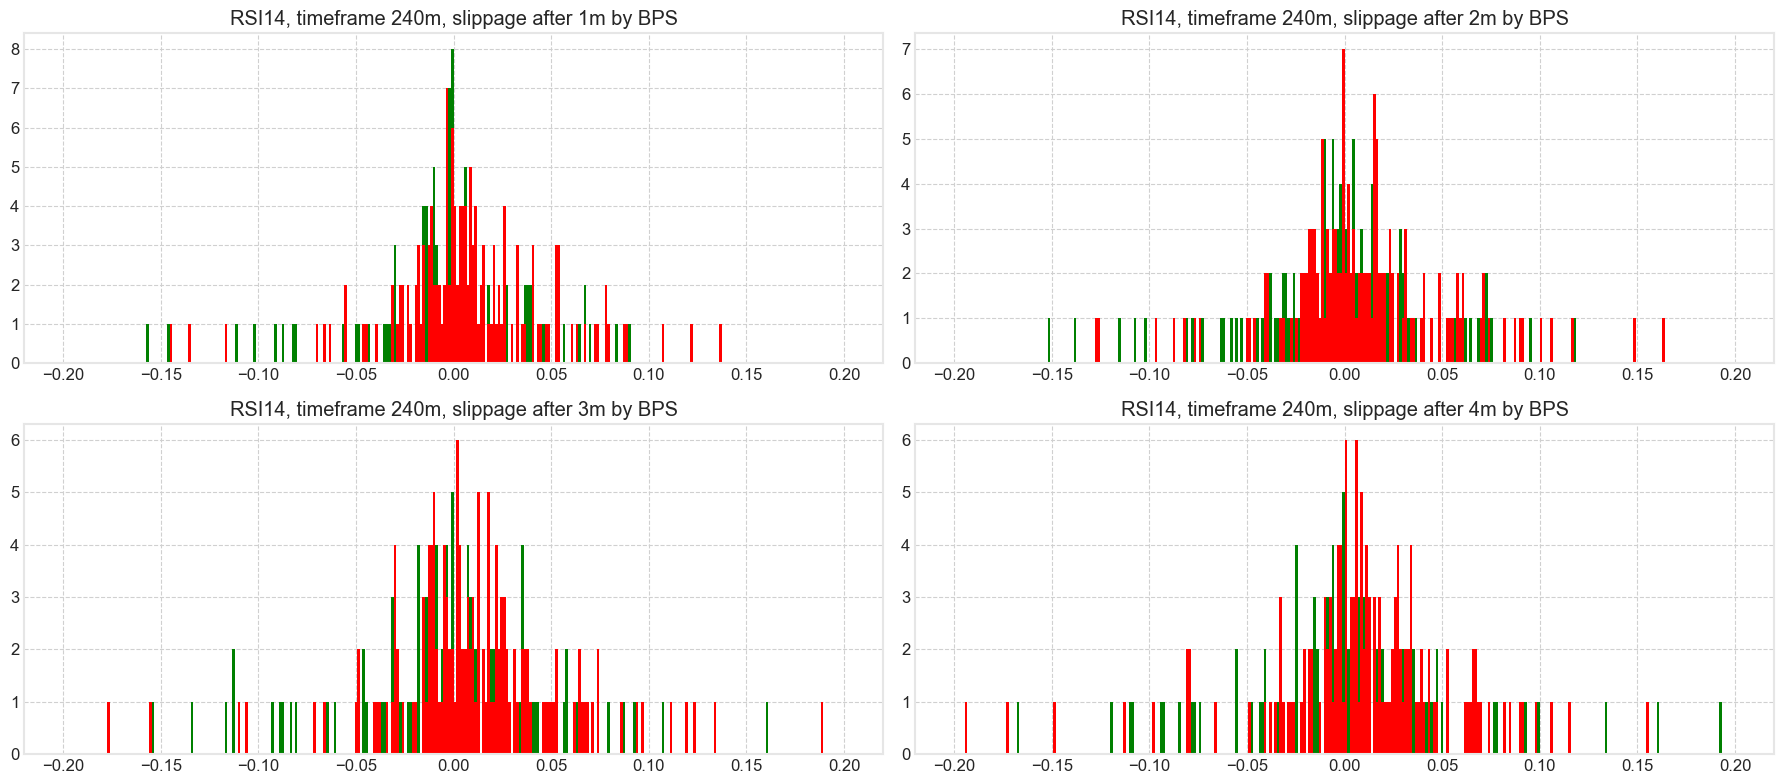

In [26]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-0.2, 0.2)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();